<a href="https://colab.research.google.com/github/JacoboNeuro/UnSrWolo/blob/main/HCP_fMRI_n_back_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
Install dependencies, imports, download data
(all copied over from the nma notebook and nilearn)

## Set up enviornment

In [ ]:
# Install nilearn
!pip install nilearn --quiet

# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import nilearn
import scipy

from nilearn.glm.first_level import make_first_level_design_matrix, run_glm
from nilearn import plotting, datasets
from nilearn.glm.contrasts import compute_contrast


# Mount google drive
drive.mount('/content/drive')

# Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# Experiment Details
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = { # EXPERIMENTS["WM"]["cond"]
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

# NMA provides an atlas. Run this cell to download it
import os, requests


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.2 MB/s eta 0:00:00
Mounted at /content/drive


## Download HCP Data

In [ ]:
# Download HCP Data
# Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)


# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

## Helper functions

In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

# First Level GLM

The following code is based on the tutorial from nilearn on [surface based first-level GLM analysis](https://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_localizer_surface_analysis.html).

The data structure in the tutorial doesn't quite match the data provided by neuromatch.

The neuromatch HCP data has the following structure:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data) -
          The structure of this data is region x time point
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Functions for 1st Level GLM

The first function, format_evs, takes in the Neuromatch-provided EVs and turns them into a Nilearn format

In [ ]:
def format_evs(ev_array, exp):
  """
  Convert HCP evs into nilearn format

  Args:
    ev_array     : ev data
    exp(string)  : experiment name

  Returns:
    df    : the events and associated conditions (pandas df)
  """

  ev_array = np.array(ev_array)
  df = pd.DataFrame(columns=['trial_type', 'onset', 'duration'])

  rc = 0
  for idx, arr in enumerate(ev_array):

    cond = EXPERIMENTS[exp]["cond"][idx]

    for x in arr:
      for ts in x:
        row = [cond, ts, 1.0]
        df.loc[rc]=row
        rc += 1
  return(df)

fl_glm takes in the subject's data, and outputs the first level GLM.

(This one is hard-coded for the specific contrast we're looking at, so make sure to edit for different contrasts)

In [ ]:
def fl_glm(data, evs):
    """
    Takes in time series data, outputs 1st level GLM

    Args:
      ev_array     : ev data
      exp(string)  : experiment name

    Returns:
      df    : the events and associated conditions (pandas df)

    """

    # Build design matrix for GLM
    t_r = 0.72

    n_scans = data.shape[1]
    frame_times = t_r * (np.arange(n_scans))

    design_matrix = make_first_level_design_matrix(frame_times,
                                               events=events,
                                               hrf_model='glover + derivative'
                                               )

    # Initialize GLM
    labels, estimates = run_glm(data.T, design_matrix.values)

    # For practical purpose, we first generate an identity matrix whose size is the number of columns of the design matrix.
    contrast_matrix = np.eye(design_matrix.shape[1])

    # First make basic contrasts
    basic_contrasts = dict([(column, contrast_matrix[i])
                            for i, column in enumerate(design_matrix.columns)])

    # Add intermediate contrasts
    basic_contrasts['condition'] = (
        basic_contrasts['2bk_body']
        + basic_contrasts['2bk_faces'])

    # Add relevant contrasts

    contrasts = {
        'body - faces': (
            basic_contrasts['2bk_body']
            - basic_contrasts['2bk_faces']
        )
    }


    contrast_val = contrasts['body - faces']

    fsaverage = datasets.fetch_surf_fsaverage()


    # Compute the contrast
    contrast = compute_contrast(labels, estimates, contrast_val,
                                contrast_type='t')

    # Calculate z-score from contrast
    z_score = contrast.z_score()

    return(z_score)


### Test out the functions above

In [ ]:
"""
# Load some test data
test_data = load_single_timeseries("101915", "WM", 0)
print(f"The shape of the HCP fMRI data is: {test_data.shape}, the shape of the regions list is {regions.shape}")
print("This means the fMRI data has the dimensions of region x time point")

print(test_data)


fmri_image = test_data

# Test format_evs function
test_evs = load_evs(subject="101915", experiment="WM", run=0)
test_evs = np.array(test_evs)
#print(test_evs)


# Turn EVs into nilern tutorial style events dataframe
events = format_evs(test_evs, "WM")

# Subset for just face and body events
subset_conditions = ["2bk_body", "2bk_faces"]

events = events.query("trial_type in @subset_conditions")

z_score = fl_glm(test_data, events)
"""

'\n# Load some test data\ntest_data = load_single_timeseries("101915", "WM", 0)\nprint(f"The shape of the HCP fMRI data is: {test_data.shape}, the shape of the regions list is {regions.shape}")\nprint("This means the fMRI data has the dimensions of region x time point")\n\nprint(test_data)\n\n\nfmri_image = test_data\n\n# Test format_evs function\ntest_evs = load_evs(subject="101915", experiment="WM", run=0)\ntest_evs = np.array(test_evs)\n#print(test_evs)\n\n\n# Turn EVs into nilern tutorial style events dataframe\nevents = format_evs(test_evs, "WM")\n\n# Subset for just face and body events\nsubset_conditions = ["2bk_body", "2bk_faces"]\n\nevents = events.query("trial_type in @subset_conditions")\n\nz_score = fl_glm(test_data, events)\n'

In [ ]:
"""
# Plot the results of the test
fsaverage = datasets.fetch_surf_fsaverage()

# IMPORTANT NOTE DO NOT LOOSE OR YOU WILL BE SAD:
# when plotting the z score (or anything on fsaverage map), you need to convert
# the data from (360,) shape to the shape of the fsaverage voxels (10000ish)
# TO DO THIS you can take the array of of the data and go array[atlas["labels_L"]]
# which converts it to the fsaverage voxel dimensions

plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score[atlas["labels_L"]], hemi='left',
    title="body - face", colorbar=True,
    threshold=3., bg_map=fsaverage.sulc_left) #, view='medial')
"""

'\n# Plot the results of the test\nfsaverage = datasets.fetch_surf_fsaverage()\n\n# IMPORTANT NOTE DO NOT LOOSE OR YOU WILL BE SAD:\n# when plotting the z score (or anything on fsaverage map), you need to convert\n# the data from (360,) shape to the shape of the fsaverage voxels (10000ish)\n# TO DO THIS you can take the array of of the data and go array[atlas["labels_L"]]\n# which converts it to the fsaverage voxel dimensions\n\nplotting.plot_surf_stat_map(\n    fsaverage.infl_left, z_score[atlas["labels_L"]], hemi=\'left\',\n    title="body - face", colorbar=True,\n    threshold=3., bg_map=fsaverage.sulc_left) #, view=\'medial\')\n'

## 1 sample t-test on first-level analysis
Now we will use a t-test to find shared regions of activation across all subjects in the task

### Run all subjects through GLM

In [ ]:

# Setup variables
fsaverage = datasets.fetch_surf_fsaverage()
runs = [0, 1]
subset_conditions = ["2bk_body", "2bk_faces"]


# Initialize the big array that will hold all the data
all_data = []


# For every subject:
for idx, subject in enumerate(subjects):
  print(f"Processing subject {subject}")

  for run in runs:

    # Load first and second runs of fMRI data
    data = load_single_timeseries(subject, "WM", run)

    # Load 1st and 2nd EVs
    events = load_evs(subject=subject, experiment="WM", run=run )
    events = np.array(events)
    events = format_evs(events, "WM")

    # Subset for just face and body events
    events = events.query("trial_type in @subset_conditions")

    # Run GLM
    z_score = fl_glm(data, events)

    # - Save to array
    all_data.append(z_score)

    del data
    del events
    del z_score

np.save("1st_level_glm_all_subjects", np.array(all_data))

Processing subject 100307
Processing subject 100408
Processing subject 101915
Processing subject 102816
Processing subject 103414
Processing subject 103515


/usr/local/lib/python3.10/dist-packages/nilearn/glm/_utils.py:315: RuntimeWarning: divide by zero encountered in double_scalars
  cond = smax / smin


Processing subject 103818
Processing subject 105115
Processing subject 105216
Processing subject 106016
Processing subject 106319
Processing subject 110411
Processing subject 111009
Processing subject 111312
Processing subject 111514
Processing subject 111716
Processing subject 113215
Processing subject 113619
Processing subject 114924
Processing subject 115320
Processing subject 117122
Processing subject 117324
Processing subject 118730
Processing subject 118932
Processing subject 119833
Processing subject 120111
Processing subject 120212
Processing subject 122317
Processing subject 123117
Processing subject 124422
Processing subject 125525
Processing subject 126325


/usr/local/lib/python3.10/dist-packages/nilearn/glm/_utils.py:315: RuntimeWarning: divide by zero encountered in double_scalars
  cond = smax / smin
/usr/local/lib/python3.10/dist-packages/nilearn/glm/_utils.py:319: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


Processing subject 127933
Processing subject 128632
Processing subject 129028
Processing subject 130013
Processing subject 130316
Processing subject 130922
Processing subject 131924
Processing subject 133625
Processing subject 133827
Processing subject 133928
Processing subject 134324
Processing subject 135932
Processing subject 136833
Processing subject 137128
Processing subject 138231
Processing subject 138534
Processing subject 139637
Processing subject 140824
Processing subject 142828
Processing subject 143325
Processing subject 148032
Processing subject 148335
Processing subject 149337
Processing subject 149539
Processing subject 150524
Processing subject 151223
Processing subject 151526
Processing subject 151627
Processing subject 153025
Processing subject 153429
Processing subject 154431
Processing subject 156233
Processing subject 156637
Processing subject 157336
Processing subject 158035
Processing subject 158540
Processing subject 159239


/usr/local/lib/python3.10/dist-packages/nilearn/glm/_utils.py:315: RuntimeWarning: divide by zero encountered in double_scalars
  cond = smax / smin


Processing subject 159340
Processing subject 160123
Processing subject 161731
Processing subject 162329
Processing subject 162733
Processing subject 163129
Processing subject 163432
Processing subject 167743
Processing subject 172332


/usr/local/lib/python3.10/dist-packages/nilearn/glm/_utils.py:315: RuntimeWarning: divide by zero encountered in double_scalars
  cond = smax / smin


Processing subject 175439
Processing subject 176542
Processing subject 178950
Processing subject 182739
Processing subject 185139
Processing subject 188347
Processing subject 189450


/usr/local/lib/python3.10/dist-packages/nilearn/glm/_utils.py:315: RuntimeWarning: divide by zero encountered in double_scalars
  cond = smax / smin


Processing subject 190031
Processing subject 192439
Processing subject 192540
Processing subject 193239
Processing subject 194140
Processing subject 196144
Processing subject 196750
Processing subject 197550
Processing subject 198451
Processing subject 199150
Processing subject 199655
Processing subject 200614
Processing subject 201111
Processing subject 201414
Processing subject 205119


### Run t-test on 1st level GLM results

In [ ]:
all_data = np.load("1st_level_glm_all_subjects.npy")

subject_info_path = "/content/drive/MyDrive/unrestricted_tovah_7_12_2023_16_42_27.csv"

subject_info = pd.read_csv(subject_info_path, index_col=0)

subjects_int = [int(x) for x in subjects]

young = []
middle = []
old = []

idx = 0
runidx = 0

for sub in subjects:
  sub_age = subject_info.loc[subjects_int[idx]]['Age']

  for run in runs:
    if sub_age == '22-25':
      young.append(all_data[runidx])

    elif sub_age == '26-30':
      middle.append(all_data[runidx])

    else:
      old.append(all_data[runidx])

    runidx += 1

  idx += 1

In [ ]:
young = np.asarray(young)
middle = np.asarray(middle)
old = np.asarray(old)
# Run ANOVA on 1st level GLM data across subjects
youngt = young.T
middlet = middle.T
oldt= old.T

F_vals = []
p_vals = []
for roi in range(len(youngt)):
  F_vals.append(scipy.stats.f_oneway(youngt[roi], middlet[roi], oldt[roi], axis=0)[0])
  p_vals.append(scipy.stats.f_oneway(youngt[roi], middlet[roi], oldt[roi], axis=0)[1])
# Do FDR correction
# Make df with region name + p value for each ROI
# Plot significant ROIs (figure out how to label regions???)


In [ ]:
print(F_vals)

[0.17733956582347427, 0.1409367308314976, 0.4271966508514719, 0.25633376439063443, 0.09188877896206847, 0.5588545501553004, 0.8306070275181278, 0.13001861542878115, 0.06696989913805008, 0.5911079604966203, 0.08455111523108925, 1.9556931964245436, 0.3711886973607019, 0.21988854836337135, 0.3619489169700465, 0.01240605326747082, 0.2886492168867976, 0.23286060778698006, 0.796768035244357, 0.2992692146955088, 1.0017874299594074, 0.09382826664958623, 1.4176194358967773, 0.8136770987920996, 0.5192854243680074, 0.2949156191767984, 0.422911872613368, 0.09075461037615971, 1.1064942747735347, 0.09768692196978863, 0.15598871947609463, 1.8584004685959215, 0.11178602604490608, 0.7142076831702229, 0.542323443397841, 0.2647994746757393, 0.6599907767231745, 1.0049044404801724, 0.22041267209716858, 0.6320726545408492, 0.2713833919785063, 1.1627216618700127, 0.18780878790344052, 0.3339210097769109, 0.32847431724653253, 0.6192340637379147, 0.43857853432715893, 0.6609826587863024, 0.6284633198816637, 0.03

In [ ]:

cool_rois_name=["FEF","PEF", "6a", "6r", "55b", "POS2", "PCV", "7m", "7Pm", "23d", "33pr", "a32pr", "p32pr", "8BM", "8C", "i6-8", "s6-8", "6ma", "SCEF", "9-46d", "a9-46v", "p9-46v", "46", "11L", "a10p", "OFC", "FFC", "PIT", "PHA2","PHA3", "PeEc", "TF", "Dummy"]
cool_rois_idx =[10,11,96,78,12,15,27,30,29,32,58,179,60,63,73,97,98,44,43,86,85, 83,84,91,89,93,18,22,155,127,122,135, 180]
for i in range(len(cool_rois_idx)):

  parcel = cool_rois_idx[i]
  print("Parcel", cool_rois_name[i], "with parcel index ", parcel)
  print("Right is", F_vals[parcel-1], "with p of", p_vals[parcel-1])
  print("Left is", F_vals[parcel+179], "with p of", p_vals[parcel+179], "\n")



Parcel FEF with parcel index  10
Right is 0.5911079604966203 with p of 0.5546924978130827
Left is 0.21470220309526442 with p of 0.8069701925929454 

Parcel PEF with parcel index  11
Right is 0.08455111523108925 with p of 0.9189580113248764
Left is 0.002975528220321228 with p of 0.9970289390848225 

Parcel 6a with parcel index  96
Right is 0.1583266188761472 with p of 0.8536794475651247
Left is 0.7205767202236689 with p of 0.48774926081755265 

Parcel 6r with parcel index  78
Right is 0.4238935309486803 with p of 0.6550890953997008
Left is 0.038289971627181583 with p of 0.962440982761063 

Parcel 55b with parcel index  12
Right is 1.9556931964245436 with p of 0.14420325062618383
Left is 0.16548261202781686 with p of 0.8476022822960675 

Parcel POS2 with parcel index  15
Right is 0.3619489169700465 with p of 0.6967800175223904
Left is 0.2911229710858103 with p of 0.7477447513648476 

Parcel PCV with parcel index  27
Right is 0.422911872613368 with p of 0.6557297296919014
Left is 0.558815

In [ ]:
all_data = np.load("/content/1st_level_glm_all_subjects.npy")

In [ ]:
all_data.shape

(200, 360)

In [ ]:
t_vals[9]

1.5872825868326759

In [ ]:
all_data[0,0]

0.7585839224025934

### Plots of t-stat

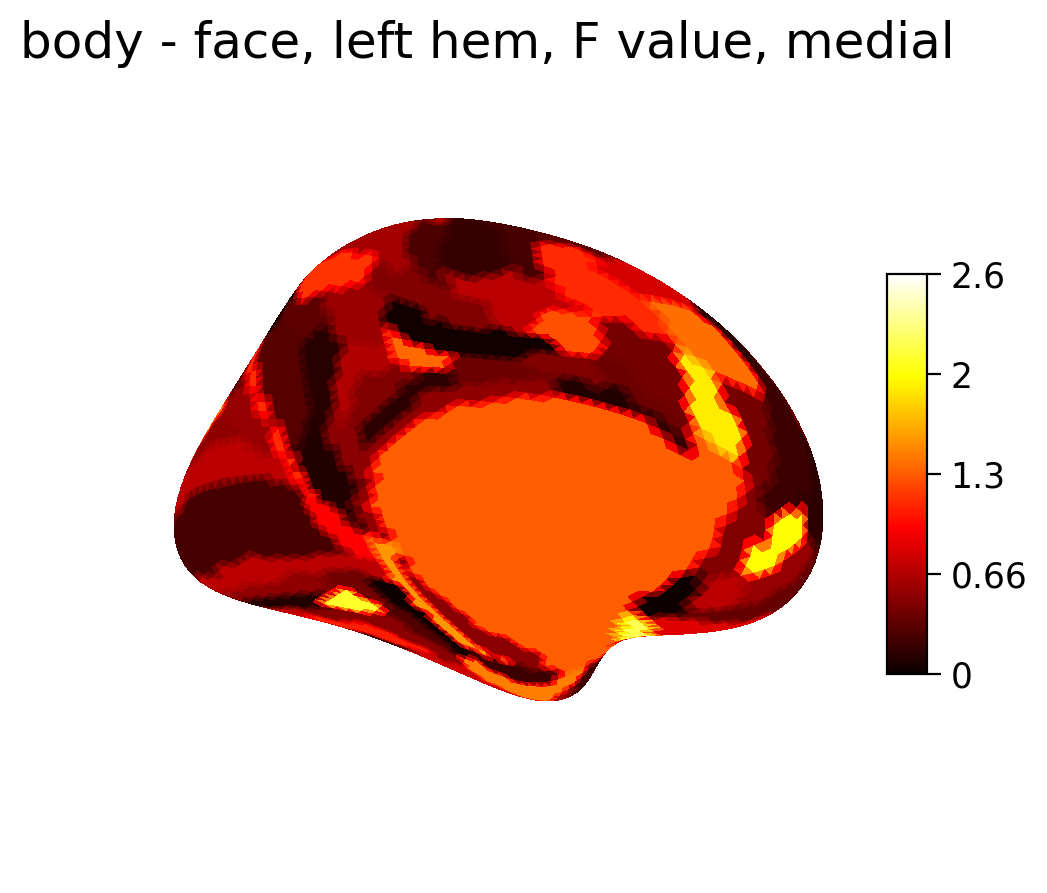

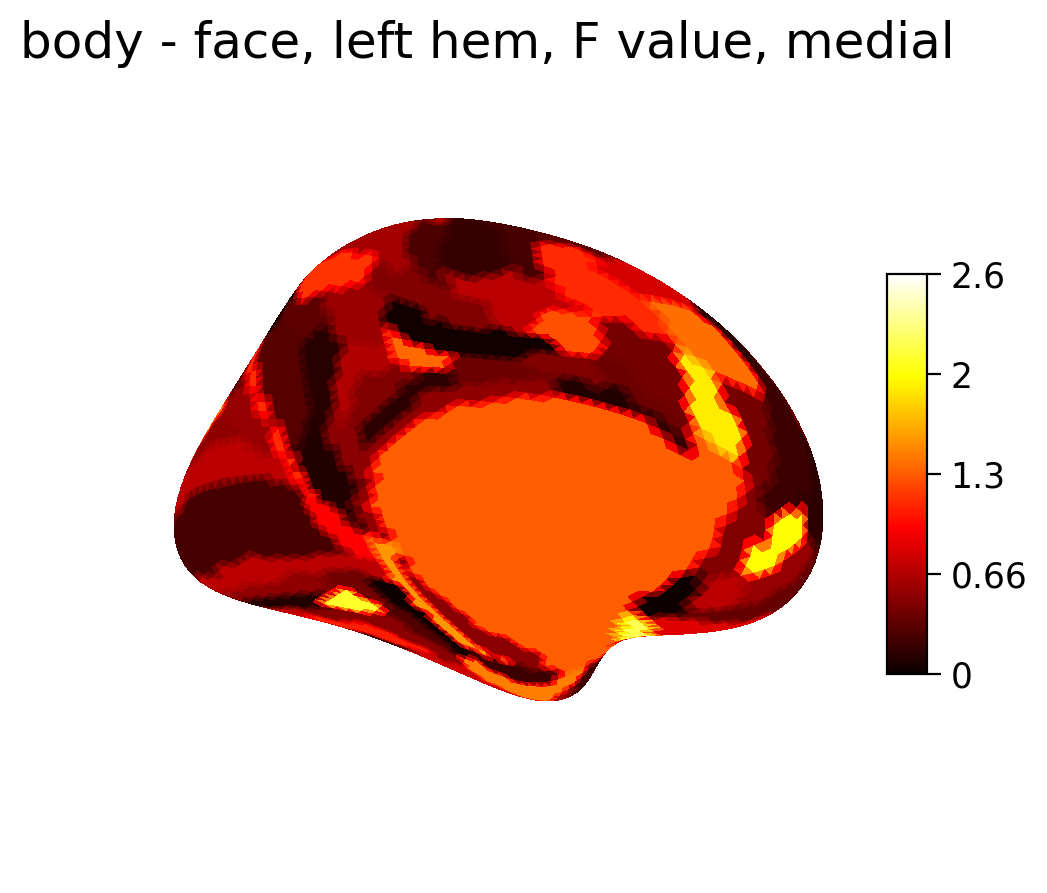

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()


plotting.plot_surf_stat_map(
    fsaverage.infl_left, np.array(F_vals)[atlas["labels_L"]], hemi='left',
    title="body - face, left hem, F value, medial", colorbar=True,
     bg_map=fsaverage.sulc_left, view='medial')


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


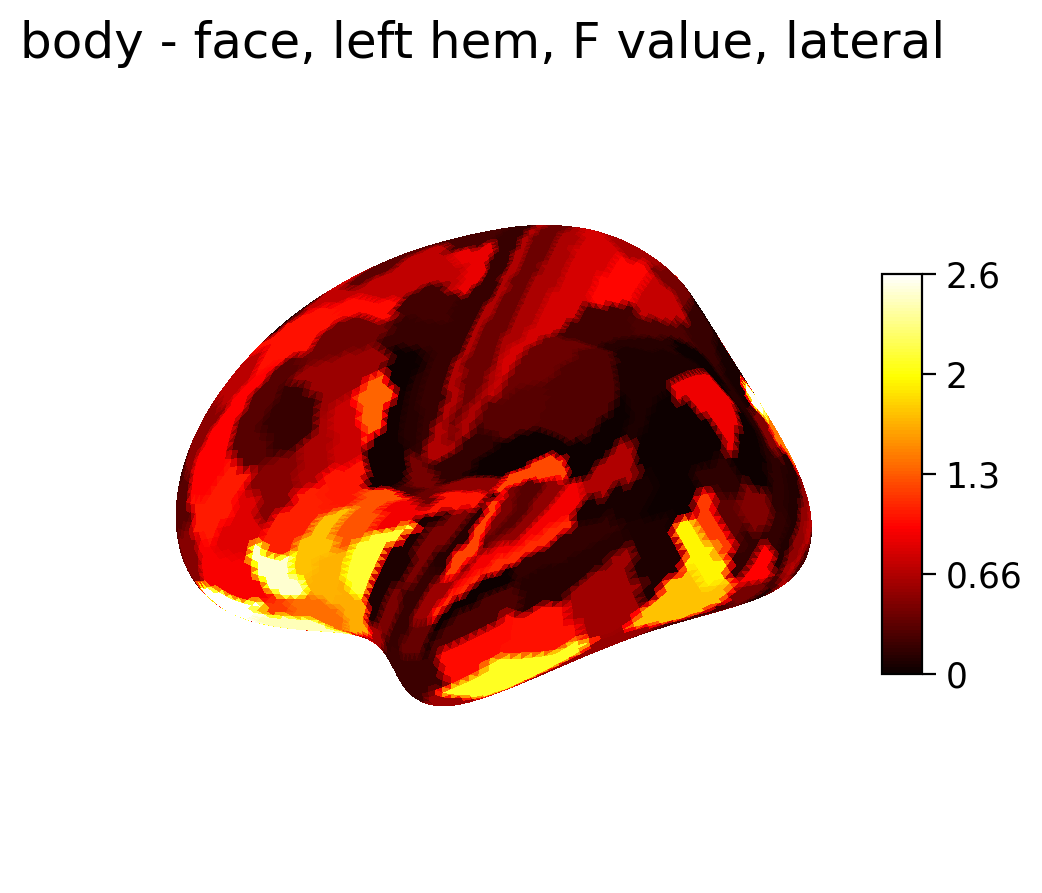

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


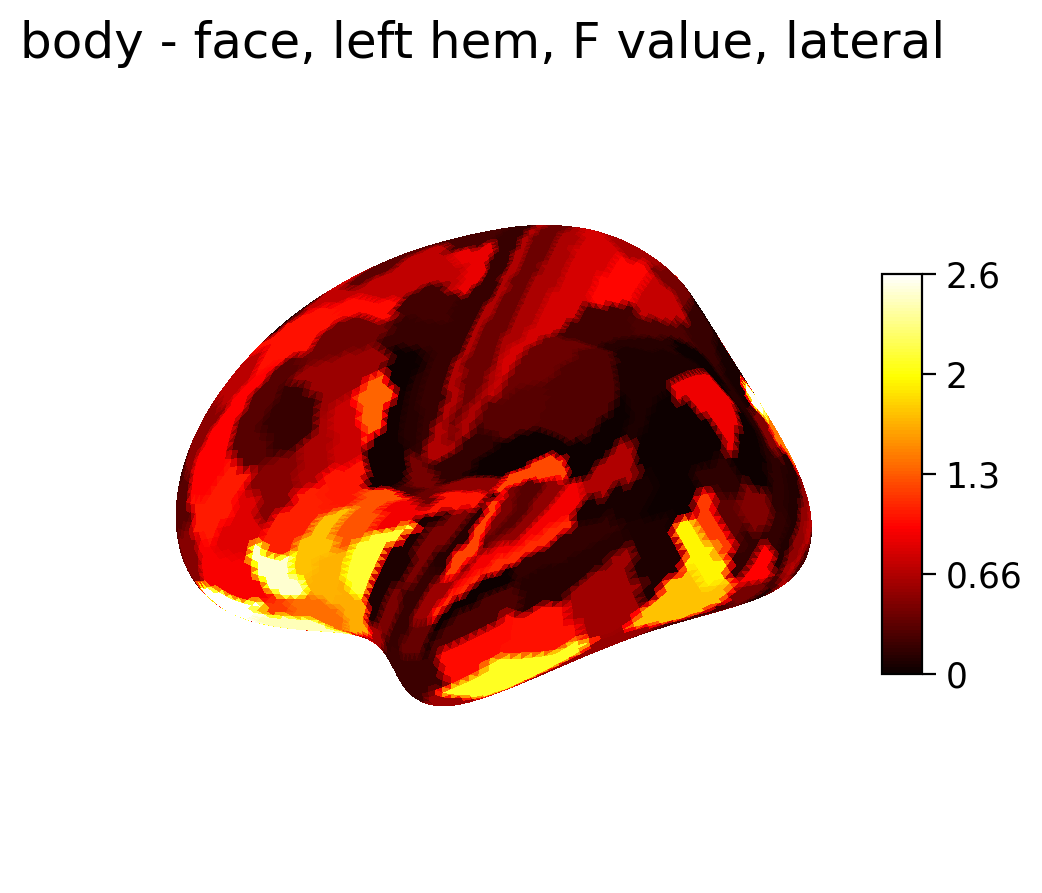

In [ ]:
plotting.plot_surf_stat_map(
    fsaverage.infl_left, np.array(F_vals)[atlas["labels_L"]], hemi='left',
    title="body - face, left hem, F value, lateral", colorbar=True,
     bg_map=fsaverage.sulc_left)


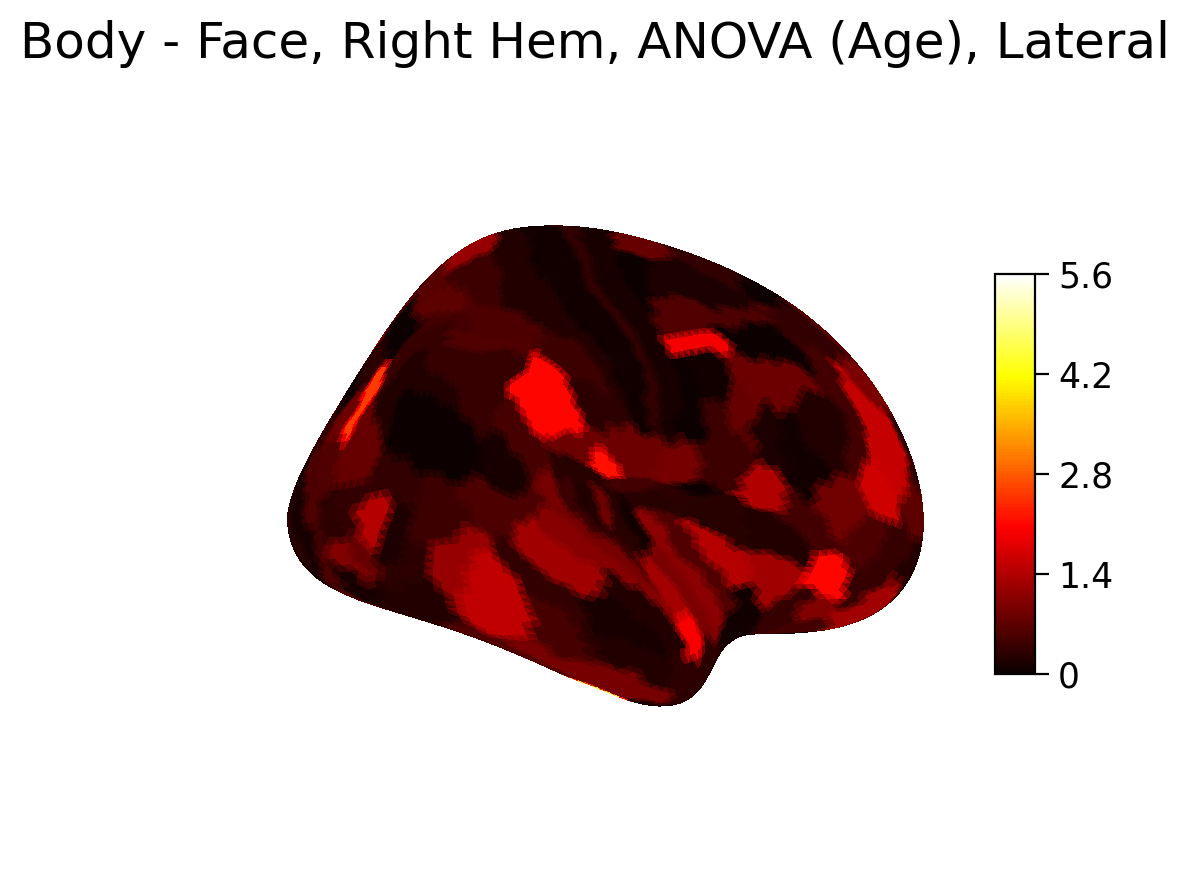

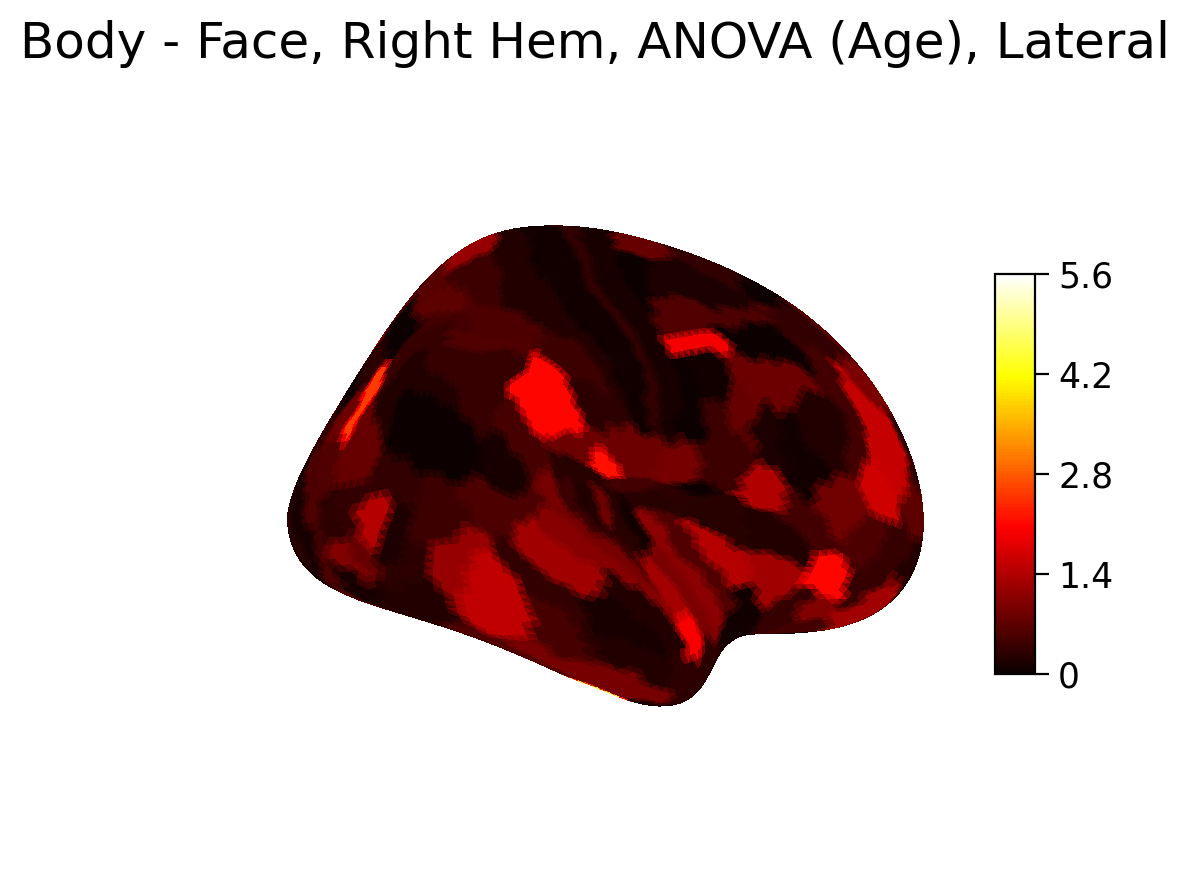

In [ ]:
plotting.plot_surf_stat_map(
    fsaverage.infl_right, np.array(F_vals)[atlas["labels_R"]], hemi='right',
    title="Body - Face, Right Hem, ANOVA (Age), Lateral", colorbar=True,
     bg_map=fsaverage.sulc_right)


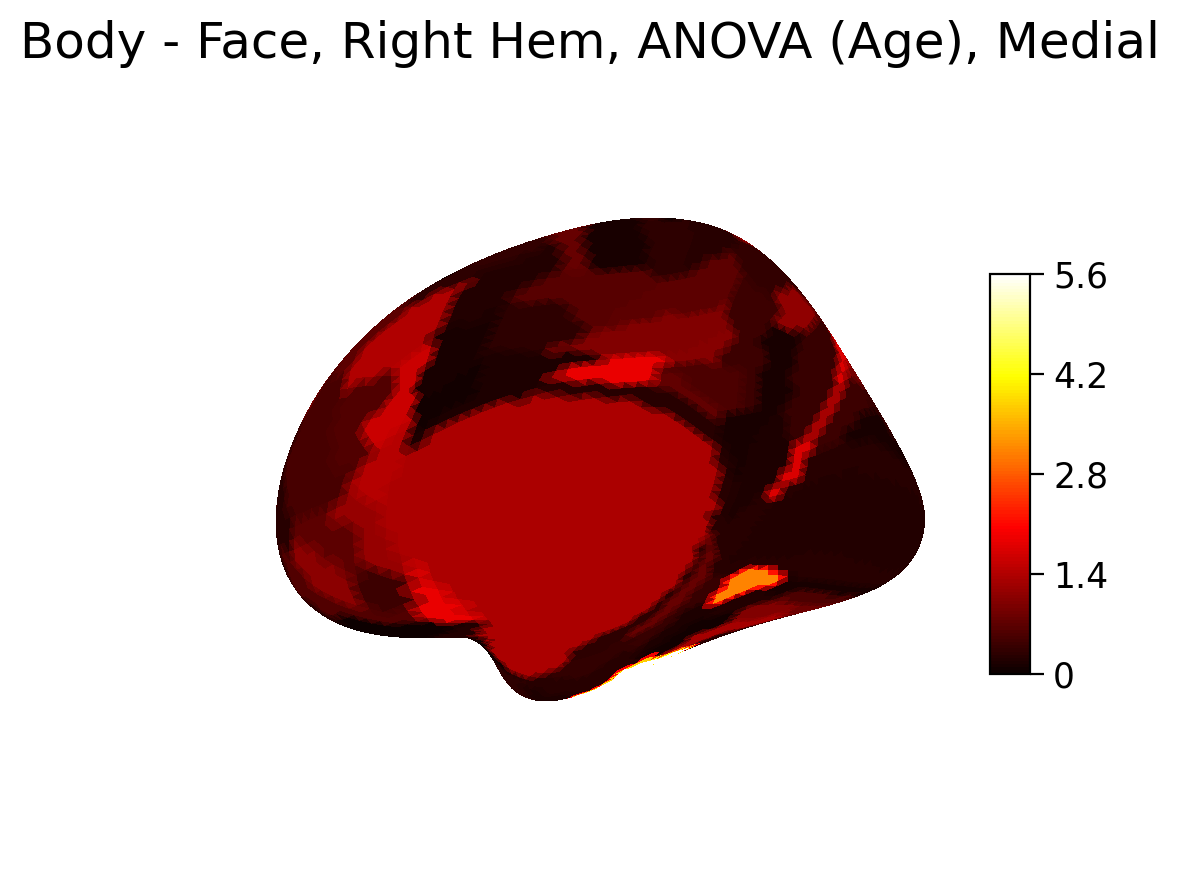

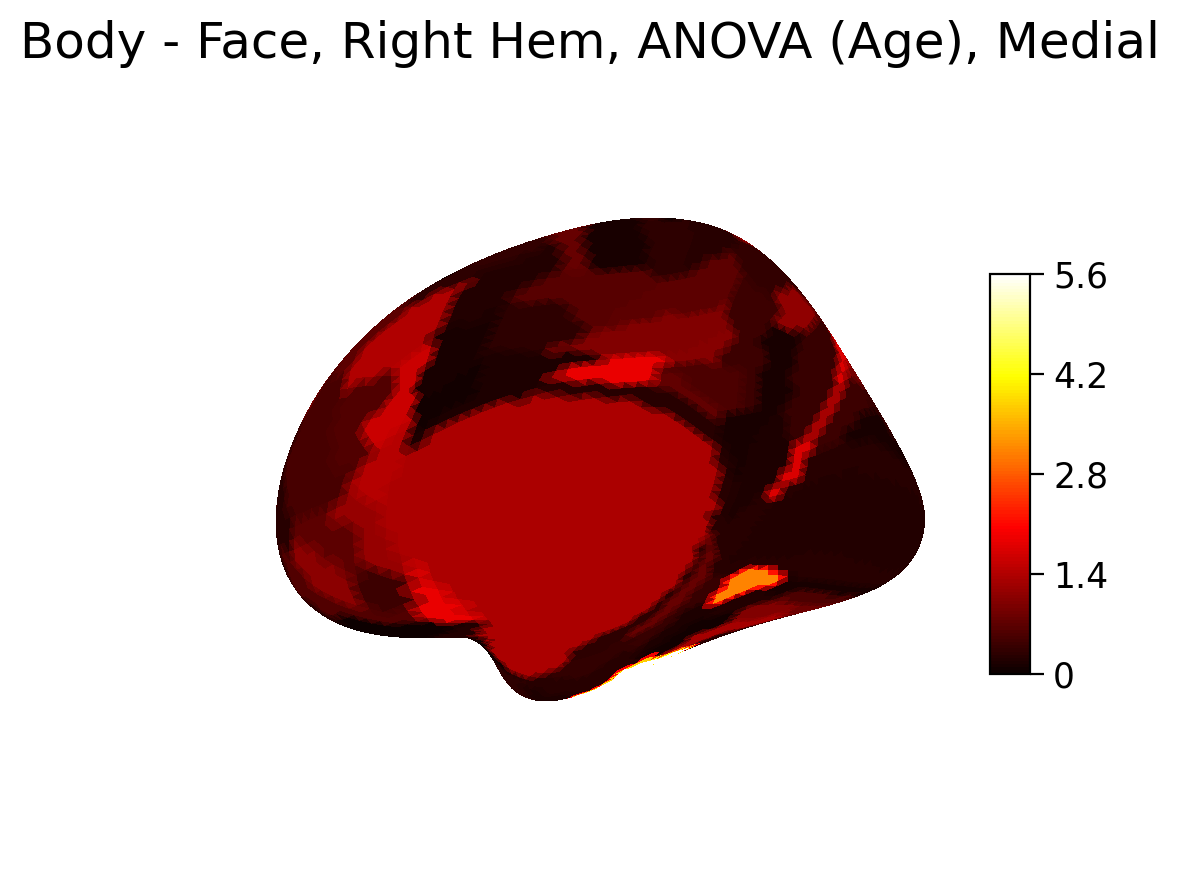

In [ ]:
plotting.plot_surf_stat_map(
    fsaverage.infl_right, np.array(F_vals)[atlas["labels_R"]], hemi='right',
    title="Body - Face, Right Hem, ANOVA (Age), Medial", colorbar=True,
     bg_map=fsaverage.sulc_right, view='medial')


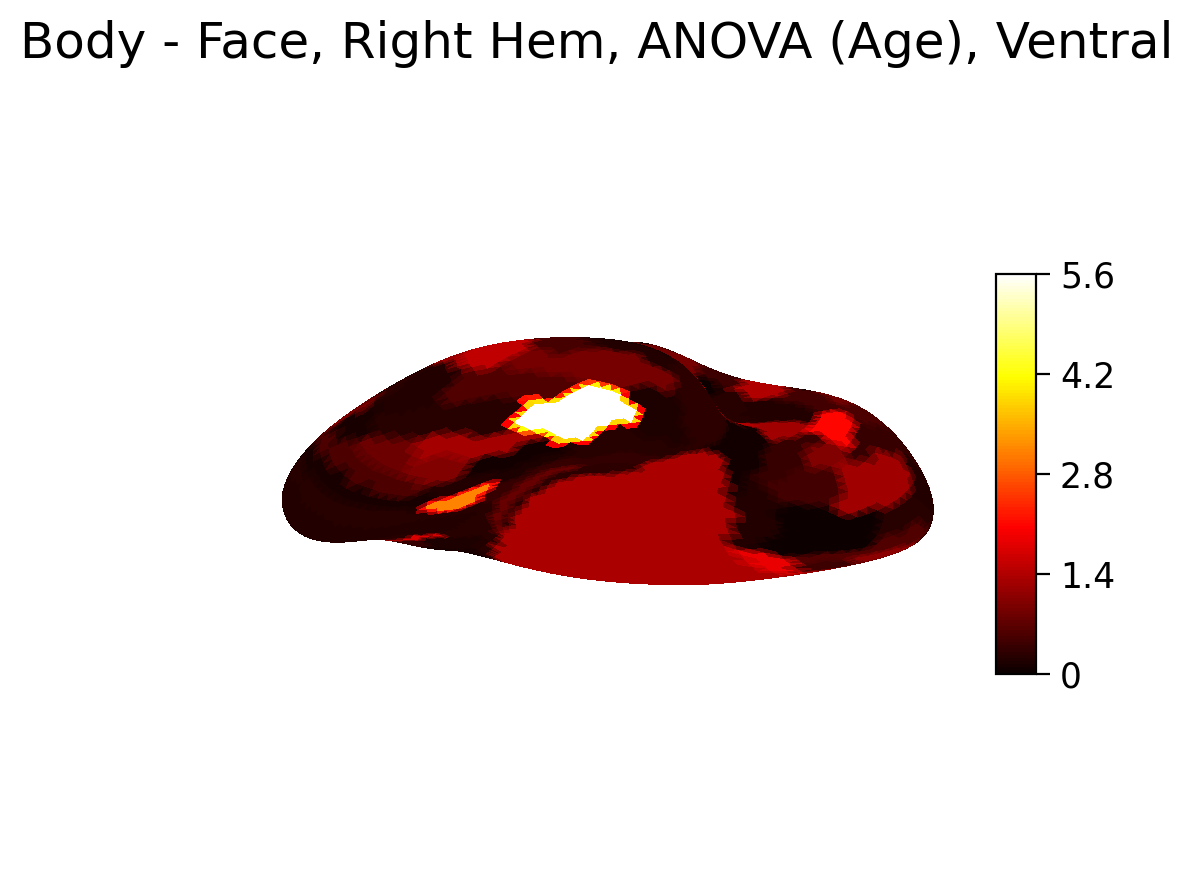

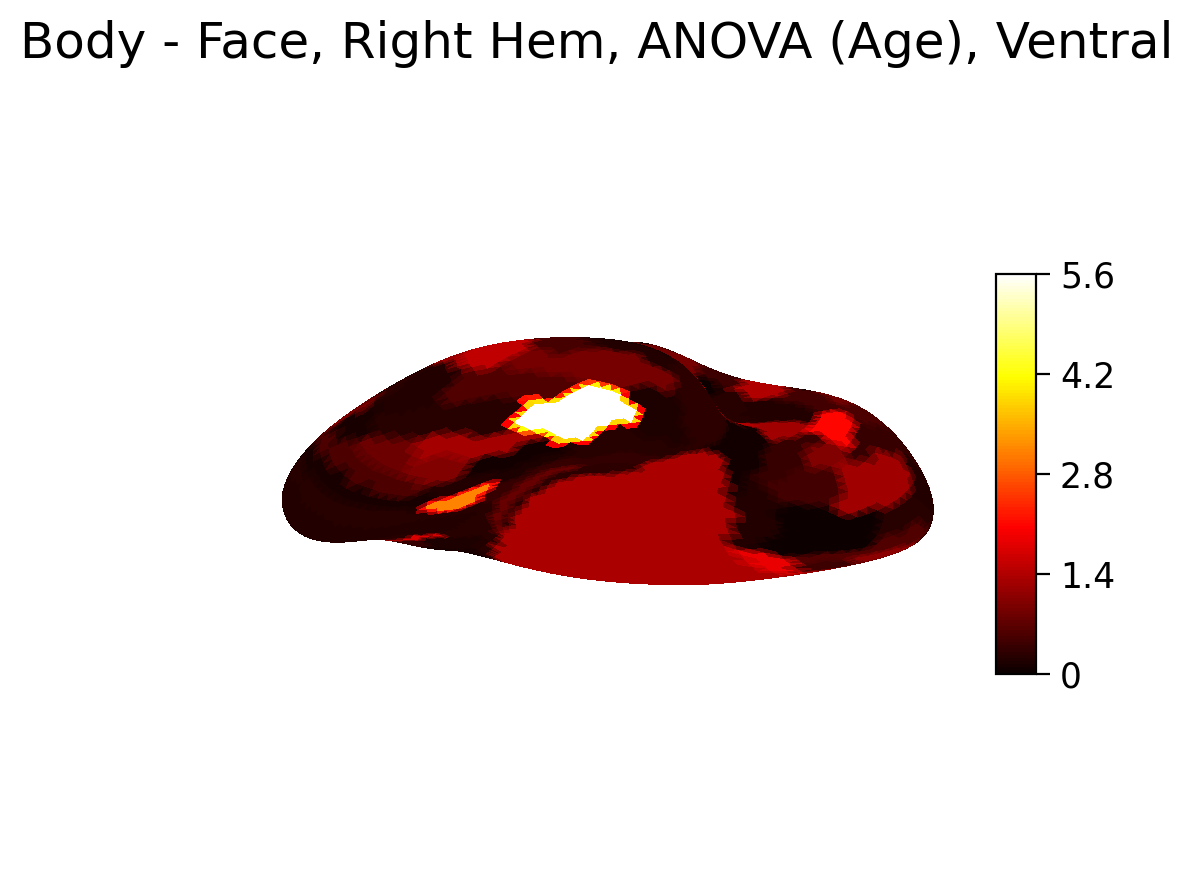

In [ ]:
plotting.plot_surf_stat_map(
    fsaverage.infl_right, np.array(F_vals)[atlas["labels_R"]], hemi='right',
    title="Body - Face, Right Hem, ANOVA (Age), Ventral", colorbar=True,
     bg_map=fsaverage.sulc_right, view='ventral')


# 2nd Level GLM analysis

## Design the 2nd Level GLM

### Read in the subject information

In [ ]:
# Get subject info for age groups

# read in file
subject_info_path = "/content/drive/MyDrive/Compneuro Group 1: Project Work/Behavioral/unrestricted_tovah_7_12_2023_16_42_27.csv"

subject_info = pd.read_csv(subject_info_path)

subjects_int = [int(x) for x in subjects]

age_groups = {"22-25": 0, "26-30": 1, "31-35": 2}
gender_groups = {"F": 0, "M": 1}

subject_info = subject_info.query("Subject in @subjects_int")

subject_info['Subject'] = subject_info['Subject'].astype(str)



/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/design_matrix.py:499: UserWarning: Attention: Design matrix is singular. Aberrant estimates are expected.
  warn(


### Make the design matrix

In [ ]:

# Make design matrix
extra_info_subjects = pd.DataFrame(
    {
        "subject_label": subject_info["Subject"],
        "22-25": [1 if x ==  "22-25" else 0 for x in subject_info["Age"]],
        "26-30": [1 if x ==  "26-30" else 0 for x in subject_info["Age"]],
        "31-35": [1 if x ==  "31-35" else 0 for x in subject_info["Age"]],
        "gender": [1 if x ==  "F" else 0 for x in subject_info["Gender"]],
    }
)

# This makes the actual design matrix object
from nilearn.glm.second_level import make_second_level_design_matrix

design_matrix = make_second_level_design_matrix( # this is where the error is
    subjects, extra_info_subjects
)

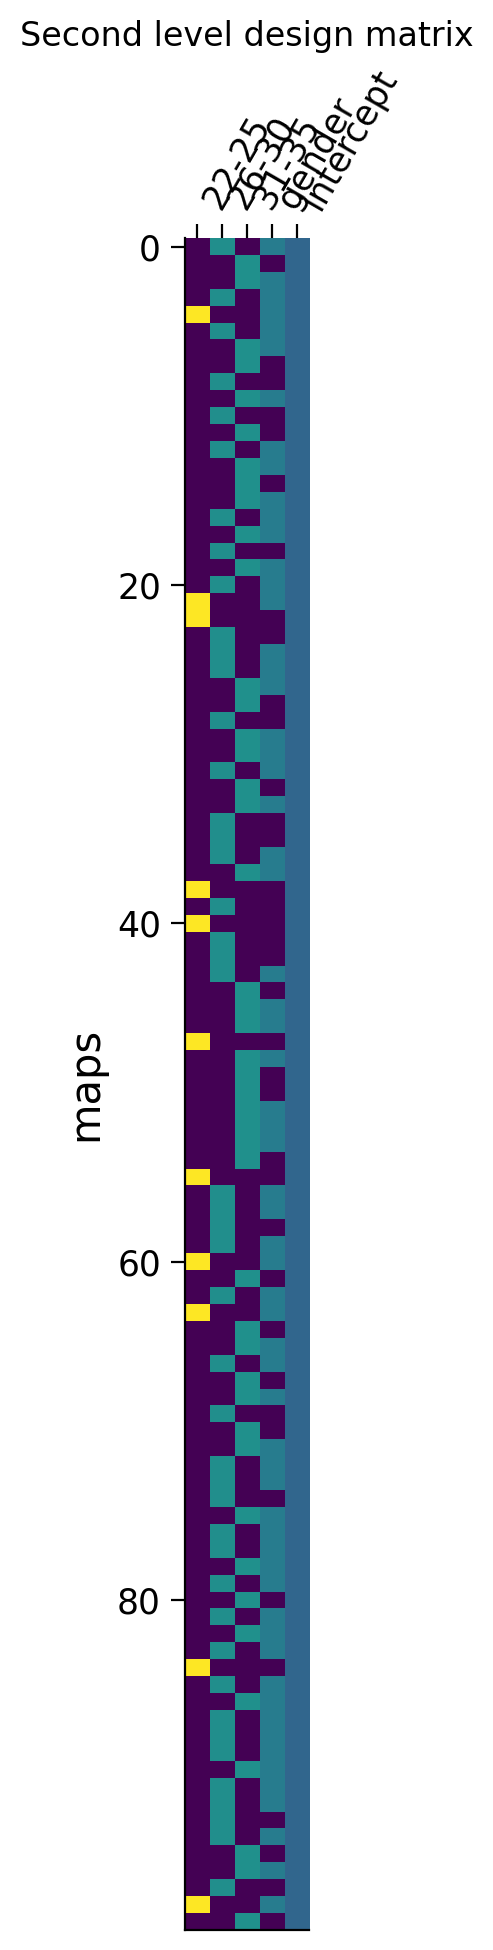

In [ ]:
# Plot the design matrix
from nilearn.plotting import plot_design_matrix

ax = plot_design_matrix(design_matrix)
ax.set_title("Second level design matrix", fontsize=12)
ax.set_ylabel("maps")
plt.tight_layout()
plt.show()


# Old Code

In [ ]:
# Test format_evs function
test_evs = load_evs(subject="101915", experiment="WM", run=0)
test_evs = np.array(test_evs)
#print(test_evs)


# Turn EVs into nilern tutorial style events dataframe
events = format_evs(test_evs, "WM")

# Subset for just face and body events
subset_conditions = ["2bk_body", "2bk_faces"]

events = events.query("trial_type in @subset_conditions")

In [ ]:
# Build design matrix for GLM
t_r = 0.72

n_scans = fmri_image.shape[1]
frame_times = t_r * (np.arange(n_scans))

In [ ]:
# Note that the output consists in 2 variables: labels and fit. labels tags
# voxels according to noise autocorrelation. estimates contains the parameter
# estimates. We keep them for later contrast computation.


from nilearn.glm.first_level import make_first_level_design_matrix

design_matrix = make_first_level_design_matrix(frame_times,
                                               events=events,
                                               hrf_model='glover + derivative'
                                               )


In [ ]:
# Note that the output consists in 2 variables: labels and fit. labels tags voxels according to noise autocorrelation.
# estimates contains the parameter estimates. We keep them for later contrast computation.

from nilearn.glm.first_level import run_glm

labels, estimates = run_glm(fmri_image.T, design_matrix.values)


In [ ]:
# For practical purpose, we first generate an identity matrix whose size is the number of columns of the design matrix.
contrast_matrix = np.eye(design_matrix.shape[1])

# First make basic contrasts
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])

# Add intermediate contrasts
basic_contrasts['condition'] = (
    basic_contrasts['2bk_body']
    + basic_contrasts['2bk_faces'])

# Add relevant contrasts

contrasts = {
    'body - faces': (
        basic_contrasts['2bk_body']
        - basic_contrasts['2bk_faces']
    )
}

In [ ]:
# Plot the 1st level GLM
from nilearn import plotting, datasets
from nilearn.glm.contrasts import compute_contrast

fsaverage = datasets.fetch_surf_fsaverage()

for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print(f"  Contrast {index + 1:1} out of {len(contrasts)}: "
          f"{contrast_id}, right hemisphere")
    # compute contrast-related statistics
    contrast = compute_contrast(labels, estimates, contrast_val,
                                contrast_type='t')
    print(contrast)
    # we present the Z-transform of the t map
    z_score = contrast.z_score()
    # we plot it on the surface, on the inflated fsaverage mesh,
    # together with a suitable background to give an impression
    # of the cortex folding.
    """
    plotting.plot_surf_stat_map(
        fsaverage.infl_left, z_score[atlas["labels_L"]], hemi='left',
        title=contrast_id, colorbar=True,
        threshold=3., bg_map=fsaverage.sulc_left, view='medial')
    """